# Makes predictions on patches and combines probabilities into a heatmap

In [2]:
import os
import numpy as np

import tensorflow as tf
import keras
import pickle as pkl

import efficientnet.keras as efn
import gc

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Cear GPU cache if needed i.e. run this before creating new model
keras.backend.clear_session()
gc.collect()

15

In [5]:
from keras import backend as K

def fRecall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def fPrecision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def fF1(y_true, y_pred):
    precision = fPrecision(y_true, y_pred)
    recall = fRecall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def fLoadModel():
    from keras.models import load_model
    cModel=load_model('/project/hackathon/hackers07/shared/cEfficientNetB4.h5',
                      custom_objects={'fF1': fF1,
                                      'fPrecision': fPrecision,
                                      'fRecall': fRecall})
    return cModel

In [6]:
cModel=fLoadModel()

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [7]:
import scipy as sp
def fNormalize(aImage):
    aImage=(aImage - np.mean(aImage))/np.std(aImage)
    aImage=sp.misc.imresize((aImage), (299,299))
    aImage=np.expand_dims(aImage, axis=2)
    return np.repeat(aImage, 3, axis=2)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


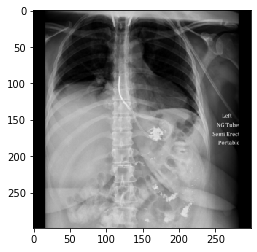

In [8]:
import imageio
aImg=imageio.imread('/project/hackathon/hackers07/shared/patchExtraction/val_images/0005.png')
aResized=fNormalize(aImg)
plt.imshow(aResized)

In [9]:
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
tf.keras.backend.set_session(tf.Session(config=config))

In [10]:
def get_windows(strImagePath, nPatchSize=512, nStride=32):
    img = imageio.imread(strImagePath)
    tupSize = img.shape
    lsPatches = []
    lsMasks = []
    for y in range(0, tupSize[0]-nPatchSize-1, nStride):
        for x in range(0, tupSize[1]-nPatchSize-1, nStride):
            arrMask = np.zeros_like(img, dtype=bool)
            arrMask[y:(y+nPatchSize), x:(x+nPatchSize)] = True
            arrPatch = img[arrMask].reshape((nPatchSize, nPatchSize))
            lsPatches += [arrPatch]
            lsMasks += [arrMask]
    #TODO: add padding for the right and bottom edges of the image
    return np.stack(lsPatches, axis=0), np.stack(lsMasks, axis=0)

In [11]:
sImagePath='/project/hackathon/hackers07/shared/patchExtraction/val_images/0050.png'

In [12]:
aImages, aMasks=get_windows(sImagePath)

In [13]:
aImages.shape

(2304, 512, 512)

In [81]:
def fMakeArray(aImages, aMasks):
    # setup array full of NAN for 
    #aFinalArray=np.ones_like(aMasks)*np.nan
    aFinalArray=np.zeros_like(aMasks, dtype=np.float64)
    
    # Make predictions
    aResized=np.zeros((aImages.shape[0],299,299,3))
    for iImage in range(aImages.shape[0]):
        aResized[iImage,:,:,:]=fNormalize(aImages[iImage,:,:])
    aPredicted=cModel.predict(aResized, verbose=1)
    for iPredicted in range(aPredicted.shape[0]):
        aFinalArray[iPredicted,aMasks[iPredicted,:,:]]=aPredicted[iPredicted][0]
    
    # Average ignoring NAN
    #aFinalArray=np.nanmean(aFinalArray, axis=0)
    #aFinalArray=np.nan_to_num(aFinalArray)
    return aFinalArray, aPredicted

In [80]:
# aFinalArray=np.zeros_like(aMasks)

# aFinalArray[0,aMasks[0,:,:]].shape=1

(262144,)

In [82]:
aFinalArray,aPredicted=fMakeArray(aImages,aMasks)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 13s 6ms/step


In [16]:
# cP1=cModel.predict(np.expand_dims(fNormalize(aImages[0,:,:]), axis=0))
# cP2=cModel.predict(np.expand_dims(fNormalize(aImages[270,:,:]), axis=0))

In [83]:
aFinalArray[0,:,:].max(), aPredicted[0][0]

(1.0527095861689872e-10, 1.0527096e-10)

In [94]:
a=np.mean(aFinalArray > 0.5, axis=0)
b=a/((np.sum(aMasks, axis=0))+1)

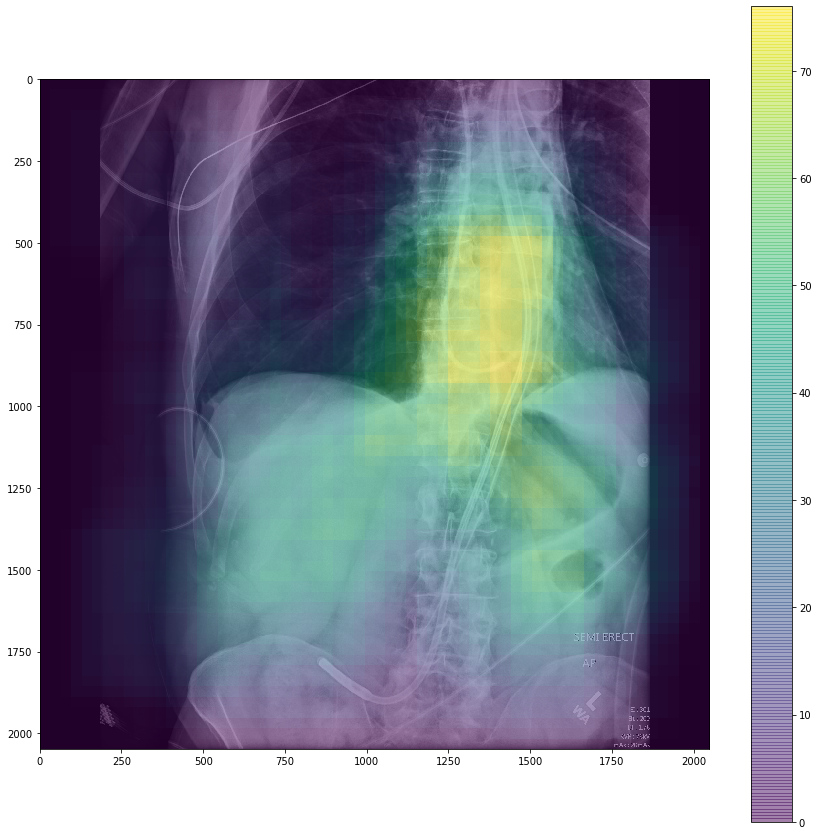

In [103]:
plt.figure(figsize=(15,15))
img = imageio.imread(sImagePath)
plt.imshow(img, cmap='Greys_r')
plt.imshow(a, alpha=0.5)
plt.colorbar()

In [97]:
sImagePath='/project/hackathon/hackers07/shared/patchExtraction/val_images/0137.png'
aImages, aMasks=get_windows(sImagePath)
aFinalArray,aPredicted=fMakeArray(aImages,aMasks)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 14s 6ms/step


In [99]:
a=np.sum(aFinalArray > 0.5, axis=0)
b=a/((np.sum(aMasks, axis=0))+1)

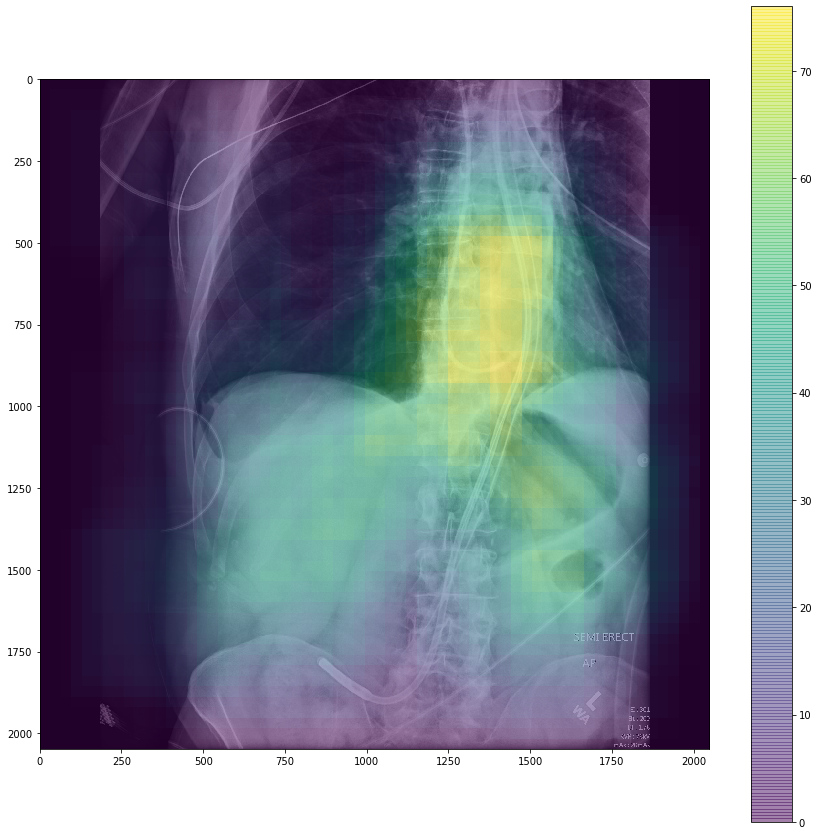

In [100]:
plt.figure(figsize=(15,15))
img = imageio.imread(sImagePath)
plt.imshow(img, cmap='Greys_r')
plt.imshow(a, alpha=0.5)
plt.colorbar()

In [128]:
def fProcessImage(sImagePath, flThresh=0.5):
    aImages, aMasks=get_windows(sImagePath)
    aFinalArray,aPredicted=fMakeArray(aImages,aMasks)
    a=np.mean(aFinalArray > flThresh, axis=0)
    b=a*((np.sum(aMasks, axis=0)))
    
    #Unnormalized
    plt.figure(figsize=(15,15))
    img = imageio.imread(sImagePath)
    plt.imshow(img, cmap='Greys_r')
    plt.imshow(a, alpha=0.36, cmap='hot',vmin=0.015, vmax=0.035)#vmax=9
    plt.colorbar() #vmax=9
    plt.savefig(f'{sImagePath.strip(".png")}_heatmap.png')
    plt.show()
    
    #Normalized
#     plt.figure(figsize=(15,15))
#     img = imageio.imread(sImagePath)
#     plt.imshow(img, cmap='Greys_r')
#     plt.imshow(b, alpha=0.5, cmap='hot', vmin=5, vmax=9)#vmax=9
#     plt.colorbar() #vmax=9
#     plt.show()

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 14s 6ms/step


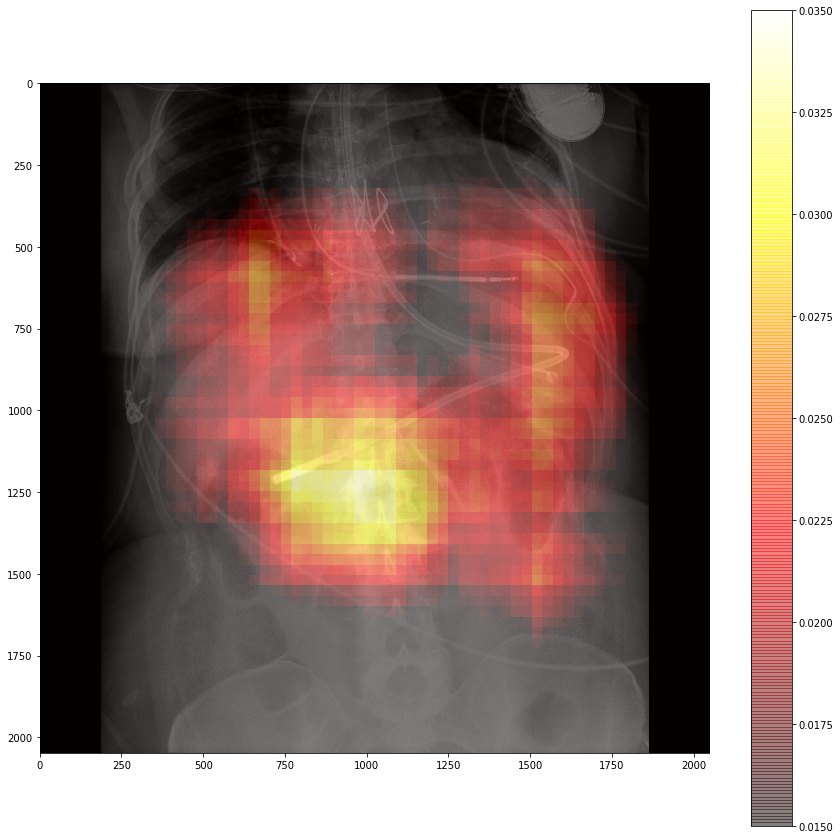

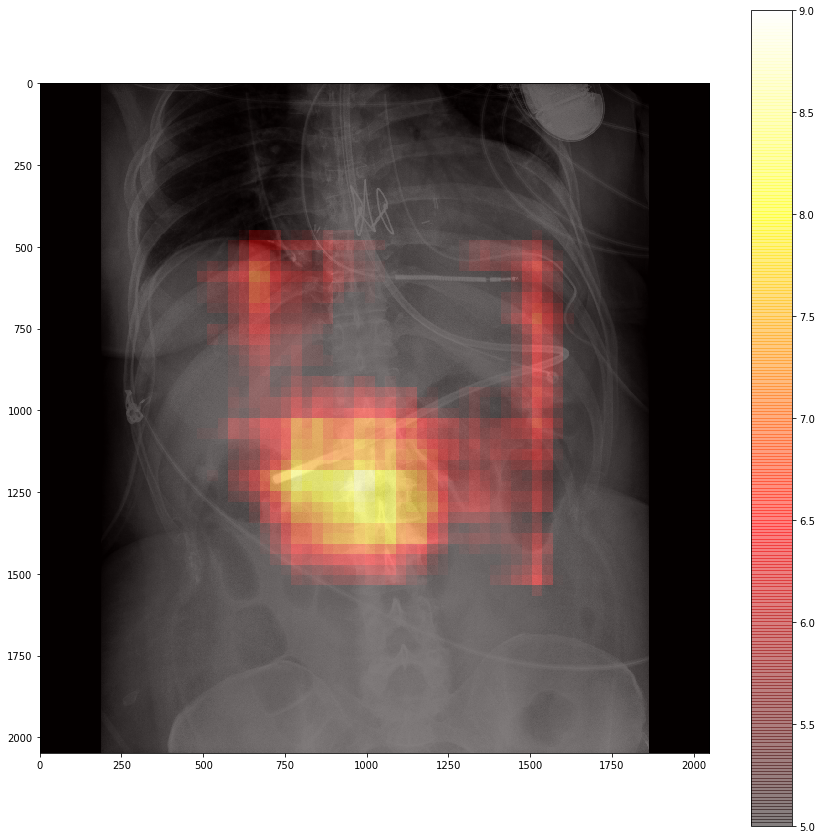

In [120]:
sImagePath='/project/hackathon/hackers07/shared/patchExtraction/val_images/0201.png'
fProcessImage(sImagePath)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 14s 6ms/step


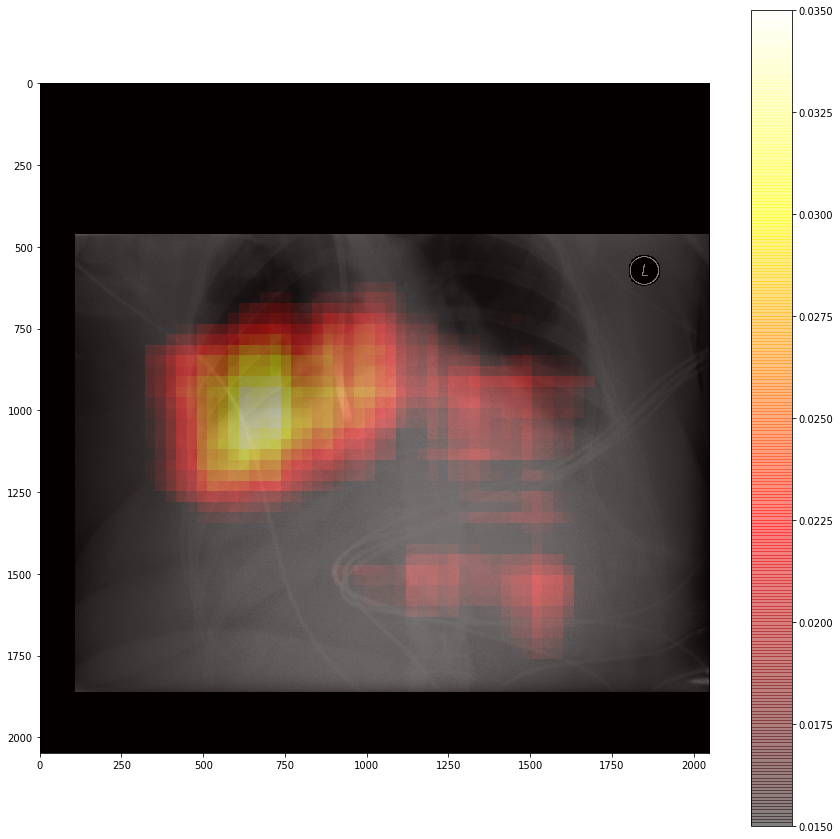

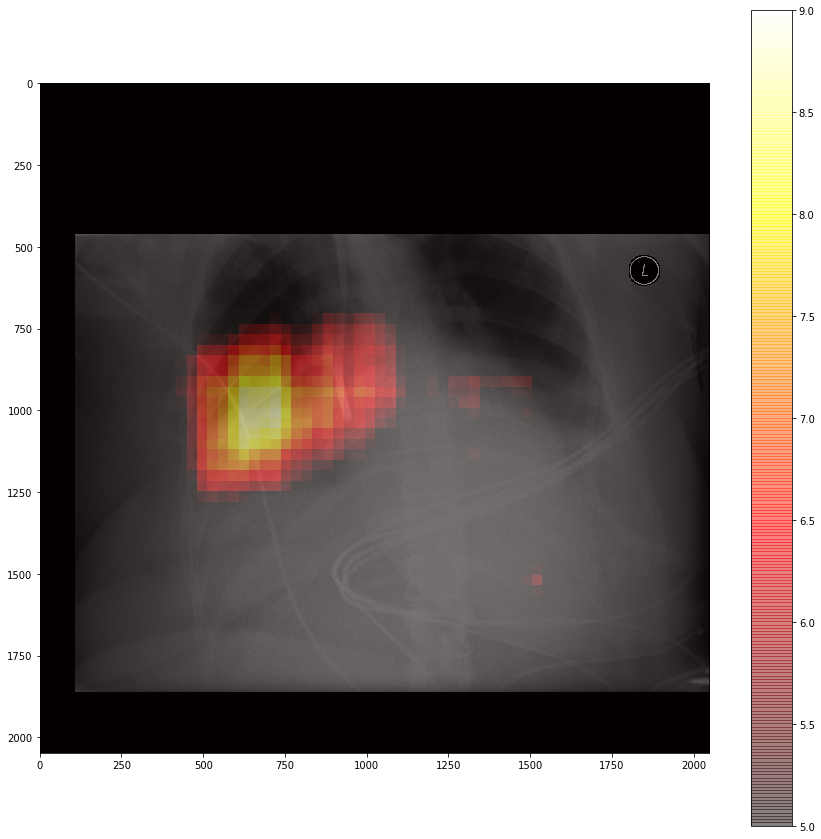

In [121]:
sImagePath='/project/hackathon/hackers07/shared/patchExtraction/val_images/0228.png'
fProcessImage(sImagePath)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 15s 7ms/step


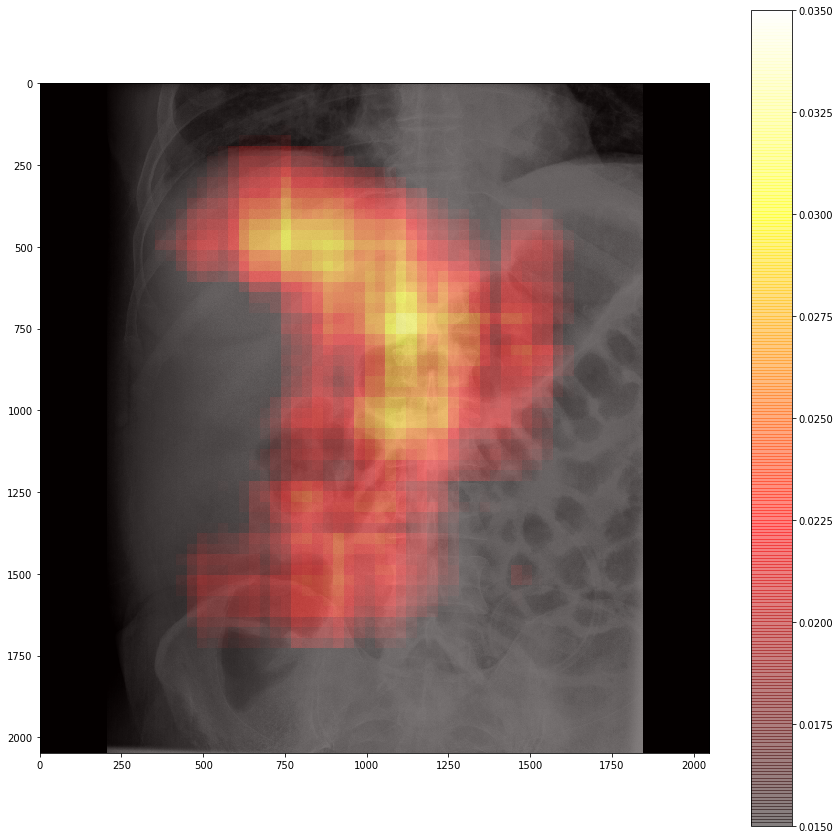

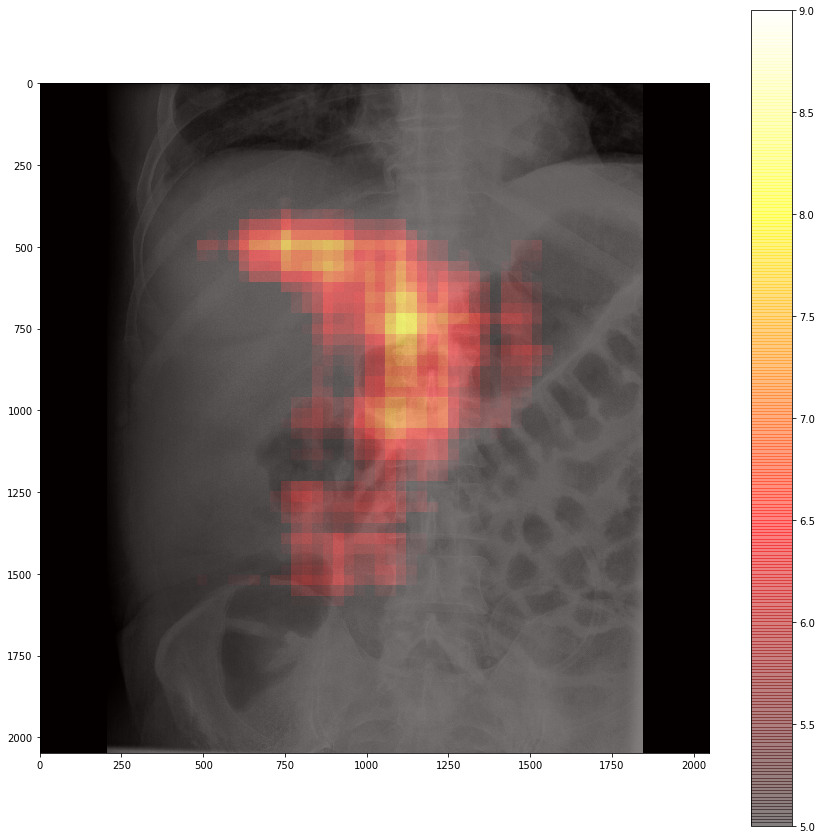

In [122]:
sImagePath='/project/hackathon/hackers07/shared/patchExtraction/val_images/0264.png'
fProcessImage(sImagePath)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 14s 6ms/step


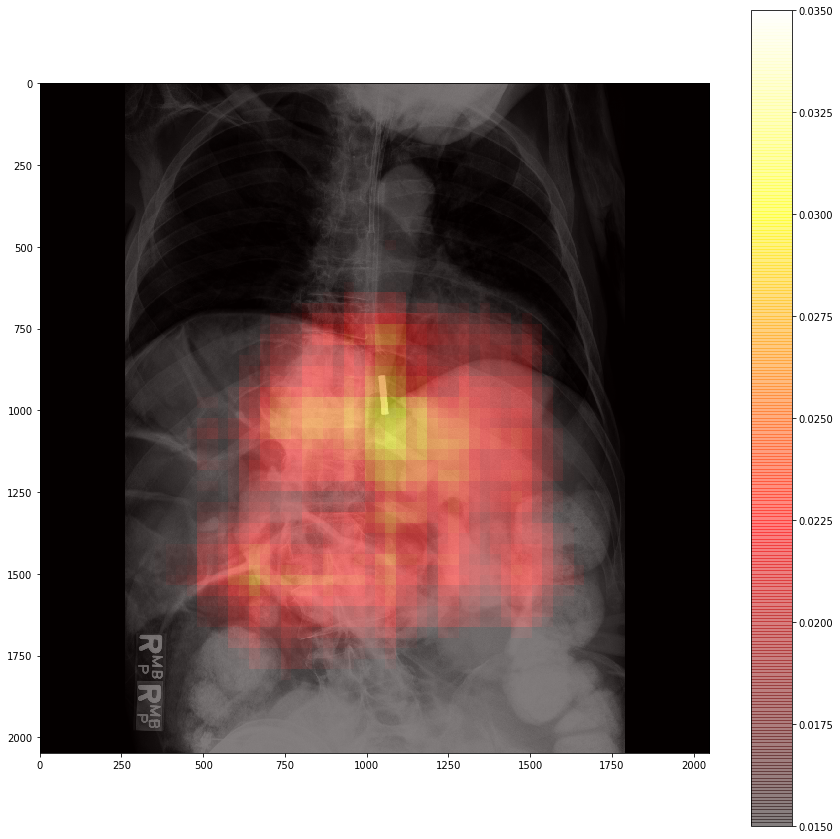

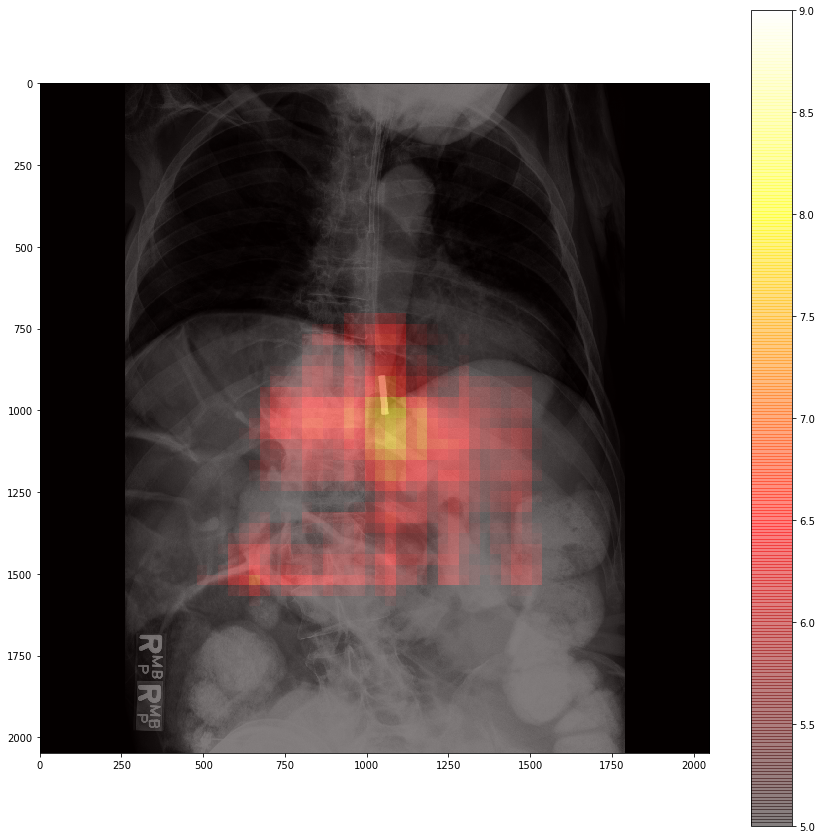

In [123]:
sImagePath='/project/hackathon/hackers07/shared/patchExtraction/val_images/0331.png'
fProcessImage(sImagePath)

In [132]:
del(a, aFinalArray, aImages, aImg, aMasks, aPredicted, aResized, b, iPredicted)

/project/hackathon/hackers07/shared/CondaEnvironments/BaseEnvironment/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


2304/2304 [==============================] - 17s 8ms/step


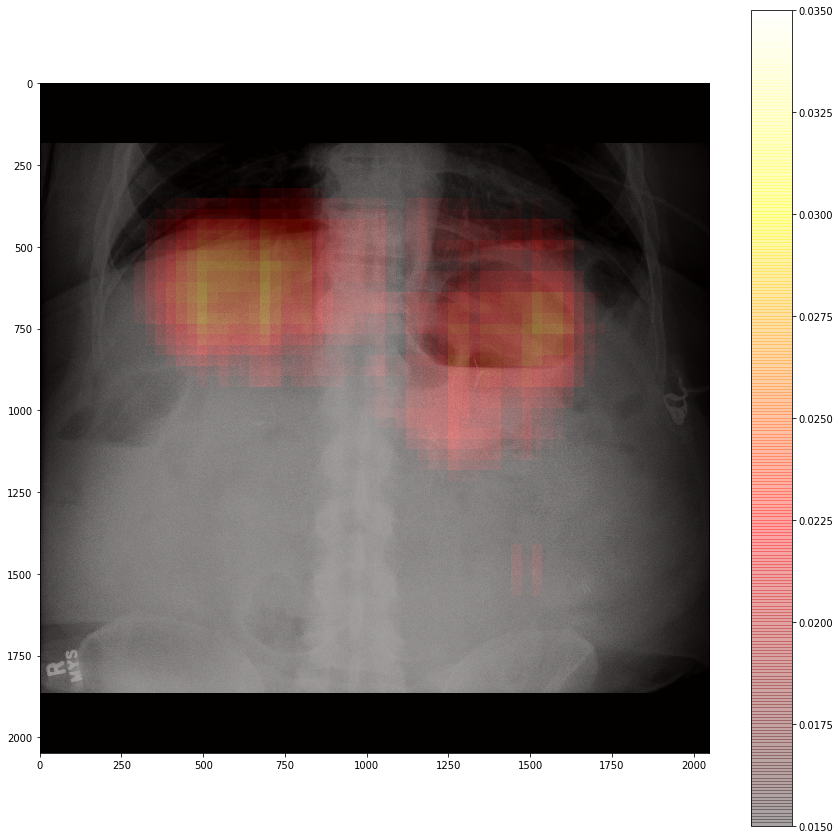

2304/2304 [==============================] - 13s 6ms/step


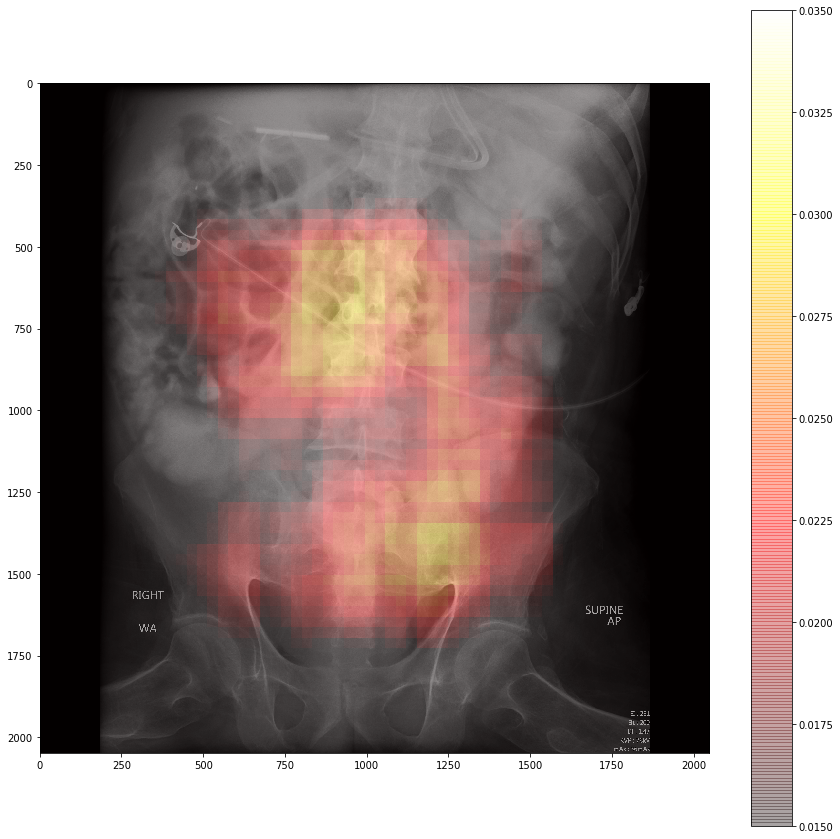

2304/2304 [==============================] - 13s 6ms/step


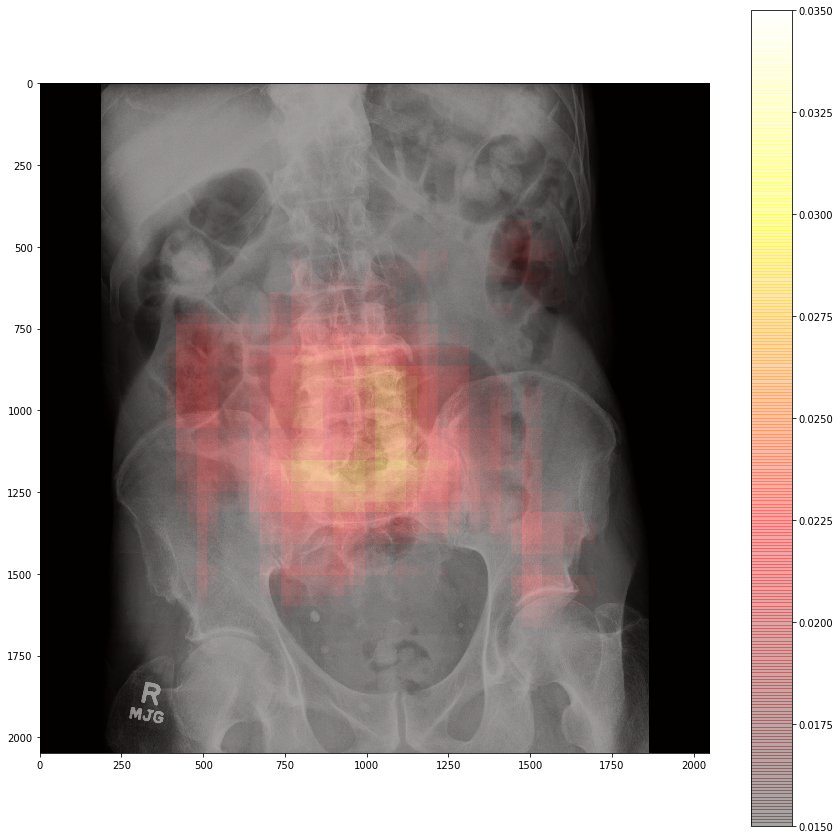

2304/2304 [==============================] - 13s 6ms/step


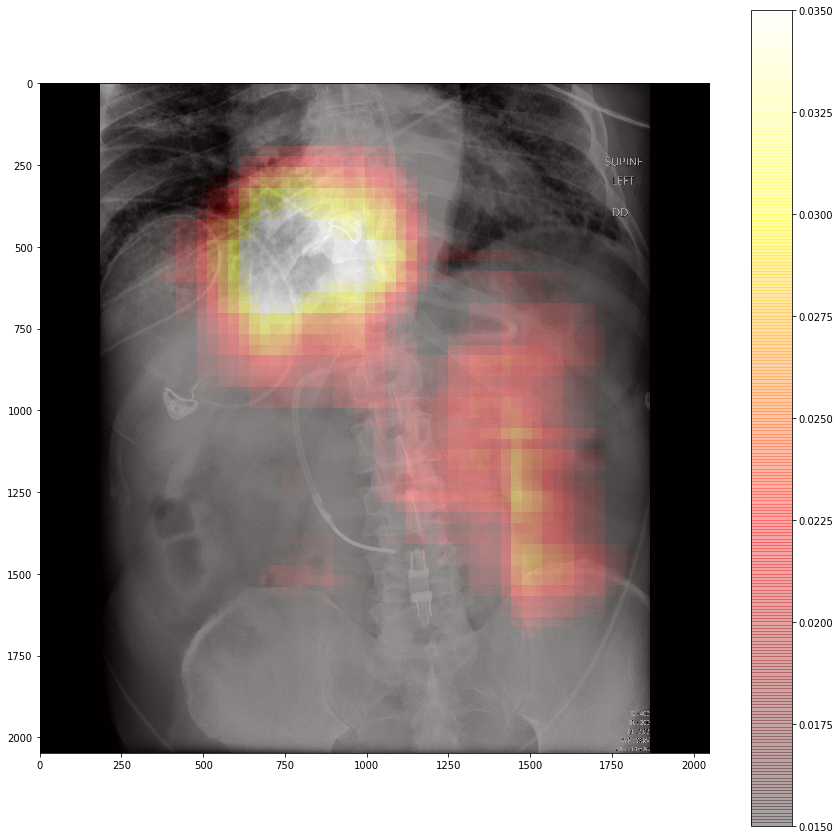

2304/2304 [==============================] - 13s 6ms/step


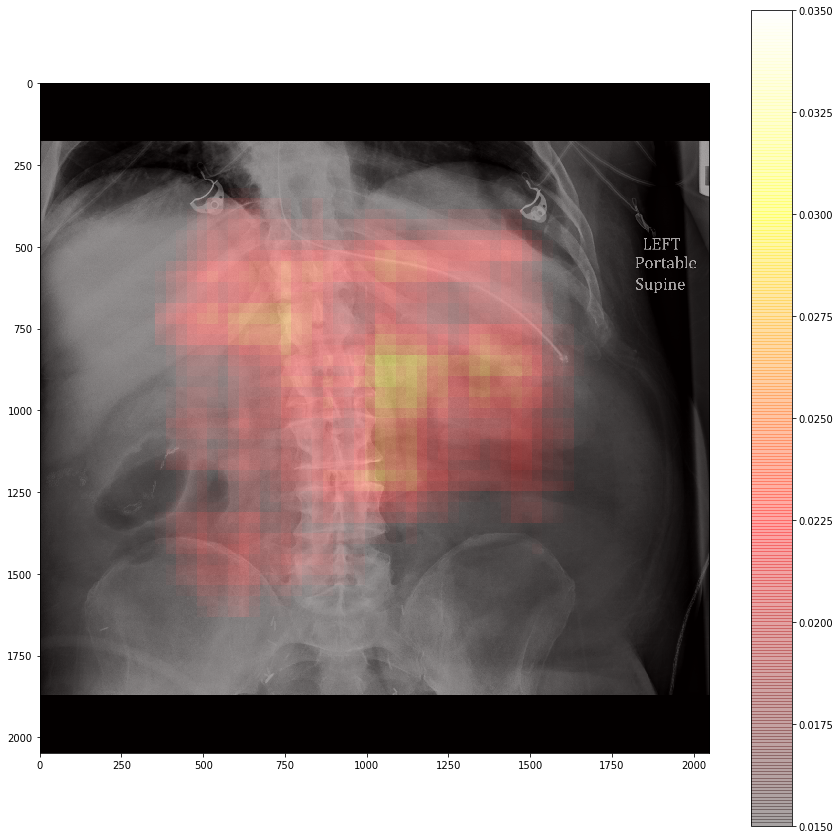

In [ ]:
import glob
for sFile in glob.glob('/project/hackathon/hackers07/shared/patchExtraction/test_images/*.png'):
    fProcessImage(sFile)